In [1]:
!pip install pandas numpy scikit-learn seaborn matplotlib lightgbm catboost xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [2]:
#!pip install pmdarima
#import pmdarima as pm
from google.colab import files
uploaded = files.upload()

Saving Data_All.xlsx to Data_All.xlsx


In [3]:
file_path = list(uploaded.keys())[0]
df = pd.read_excel(file_path, sheet_name='Cleaned')

In [4]:
# Data Preprocessing
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

df = df[['TimeStamp', 'Location', 'Station', 'PM2.5', 'SO2', 'O3', 'NO2', 'CO', 'NO',
    'AQHI', 'Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)',
    'Wind Spd (km/h)', 'Visibility (km)', 'Stn Press (kPa)']]

In [5]:
# Convert AQHI into categorical target
def categorize_aqhi(val):
    if val <= 3:
        return 'Low'
    elif 4 <= val <= 6:
        return 'Moderate'
    else:
        return 'High'

df['AQHI_Category'] = df['AQHI'].apply(categorize_aqhi)

In [6]:
# Feature selection based on correlation
numeric_data = df.select_dtypes(include='number').dropna()
corr_matrix = numeric_data.corr()
corr_with_aqhi = corr_matrix['AQHI'].abs().sort_values(ascending=False)
selected_features = corr_with_aqhi[corr_with_aqhi > 0.3].index.tolist()
if 'AQHI' in selected_features:
    selected_features.remove('AQHI')
selected_features

['PM2.5', 'Temp (°C)', 'O3']

**Regression**

In [7]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "CatBoost": cb.CatBoostRegressor(n_estimators=100, random_state=42, verbose=0),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    y_true_round = np.round(y_true).astype(int)
    y_pred_round = np.round(y_pred).astype(int)
    acc = accuracy_score(y_true_round, y_pred_round)

    return mae, mse, rmse, r2, acc


In [8]:
from sklearn.model_selection import train_test_split

# Define your two feature sets
feature_sets = {
    "Pollutants Only": ['PM2.5', 'O3', 'NO2'],
    "Pollutants + Weather": ['PM2.5', 'O3', 'NO2', 'Temp (°C)']
}

target = 'AQHI'
all_results = []

for feature_label, feature_list in feature_sets.items():
    print(f"\n=== Evaluating Feature Set: {feature_label} ===")

    for loc in df['Location'].dropna().unique():
        df_loc = df[df['Location'] == loc].copy()
        df_loc = df_loc.dropna(subset=feature_list + [target])

        X = df_loc[feature_list]
        y = df_loc[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        for name, model in models.items():
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            train_mae, train_mse, train_rmse, train_r2, train_acc = compute_metrics(y_train, y_train_pred)
            test_mae, test_mse, test_rmse, test_r2, test_acc = compute_metrics(y_test, y_test_pred)

            print(f"\nModel: {name} | Location: {loc} | Features: {feature_label}")
            print(f"Test - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}, Accuracy: {test_acc:.2f}")

            all_results.append({
                "Feature Set": feature_label,
                "Location": loc,
                "Model": name,
                "Train MAE": train_mae,
                "Train RMSE": train_rmse,
                "Train R²": train_r2,
                "Train Accuracy": train_acc,
                "Test MAE": test_mae,
                "Test RMSE": test_rmse,
                "Test R²": test_r2,
                "Test Accuracy": test_acc
            })

# convert to DataFrame for comparison or export
results_df = pd.DataFrame(all_results)



=== Evaluating Feature Set: Pollutants Only ===

Model: Linear Regression | Location: Windsor | Features: Pollutants Only
Test - MAE: 0.47, RMSE: 0.63, R²: 0.4951, Accuracy: 0.62

Model: Decision Tree | Location: Windsor | Features: Pollutants Only
Test - MAE: 0.53, RMSE: 0.84, R²: 0.0871, Accuracy: 0.55

Model: Gradient Boosting | Location: Windsor | Features: Pollutants Only
Test - MAE: 0.46, RMSE: 0.61, R²: 0.5183, Accuracy: 0.64

Model: LightGBM | Location: Windsor | Features: Pollutants Only
Test - MAE: 0.45, RMSE: 0.61, R²: 0.5234, Accuracy: 0.65

Model: Random Forest | Location: Windsor | Features: Pollutants Only
Test - MAE: 0.48, RMSE: 0.66, R²: 0.4441, Accuracy: 0.60

Model: CatBoost | Location: Windsor | Features: Pollutants Only
Test - MAE: 0.45, RMSE: 0.61, R²: 0.5155, Accuracy: 0.64

Model: AdaBoost | Location: Windsor | Features: Pollutants Only
Test - MAE: 0.62, RMSE: 0.77, R²: 0.2388, Accuracy: 0.43

Model: XGBoost | Location: Windsor | Features: Pollutants Only
Test 

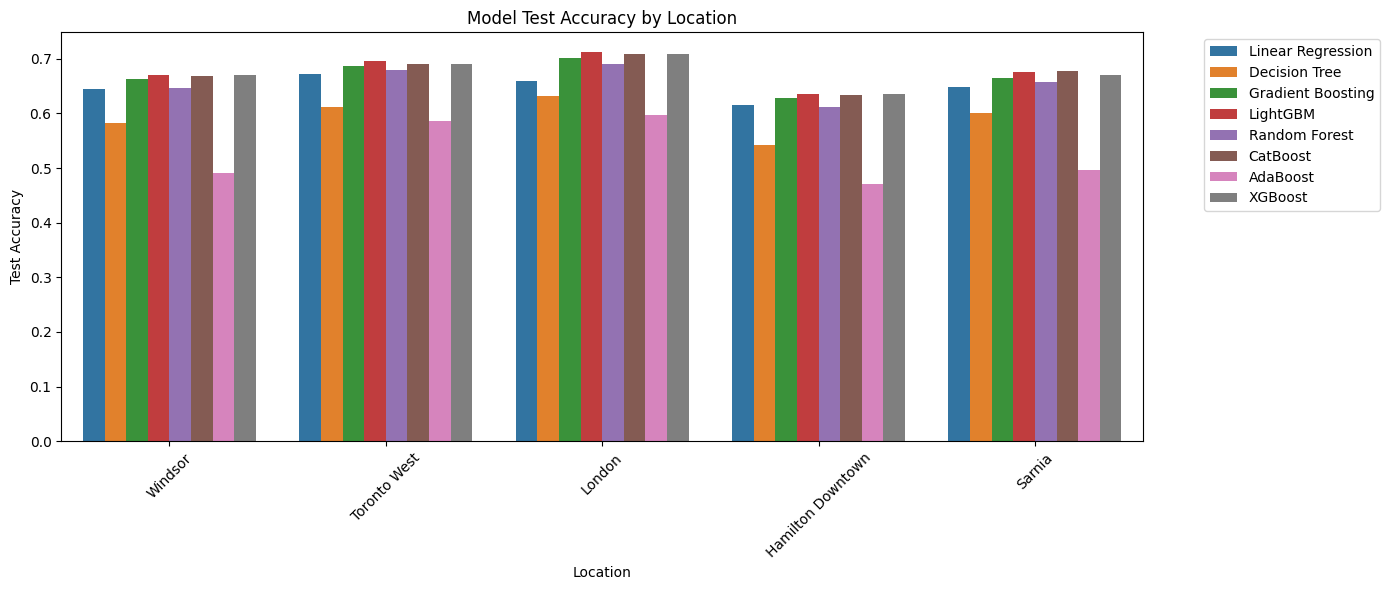

In [9]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=results_df,
    x='Location',
    y='Test Accuracy',
    hue='Model',
    errorbar=None
)
plt.title("Model Test Accuracy by Location")
plt.ylabel("Test Accuracy")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


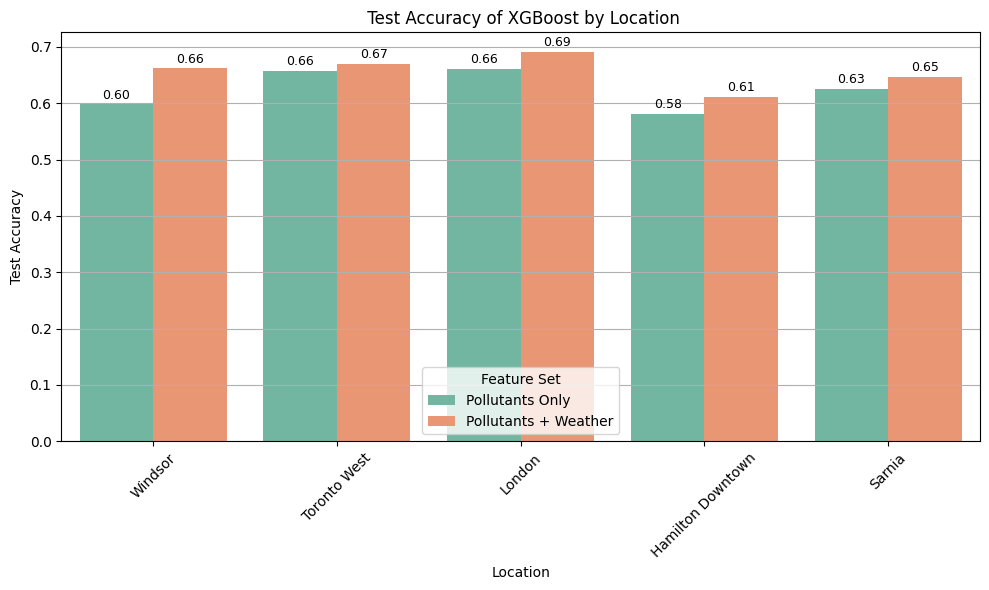

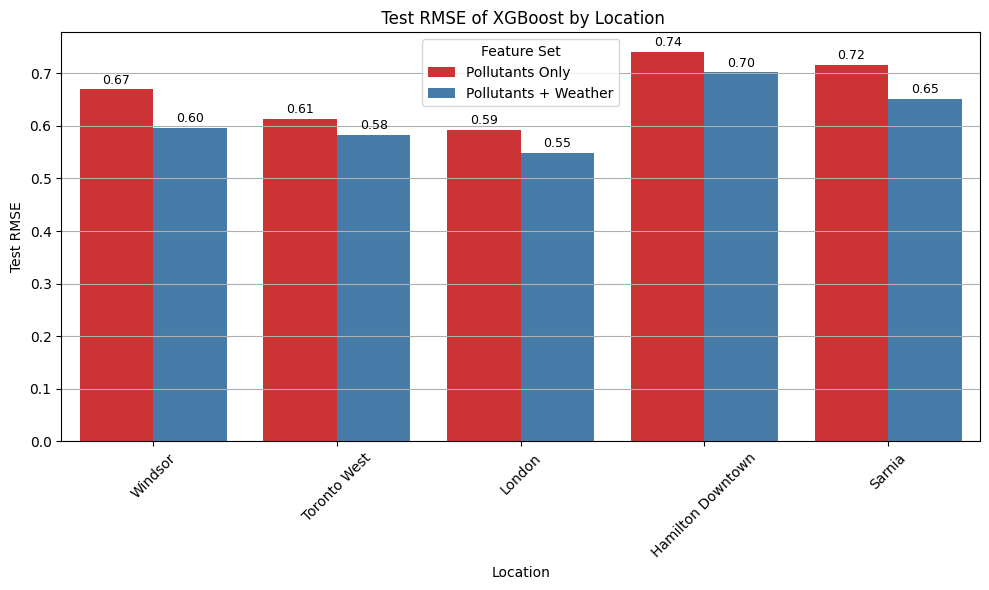

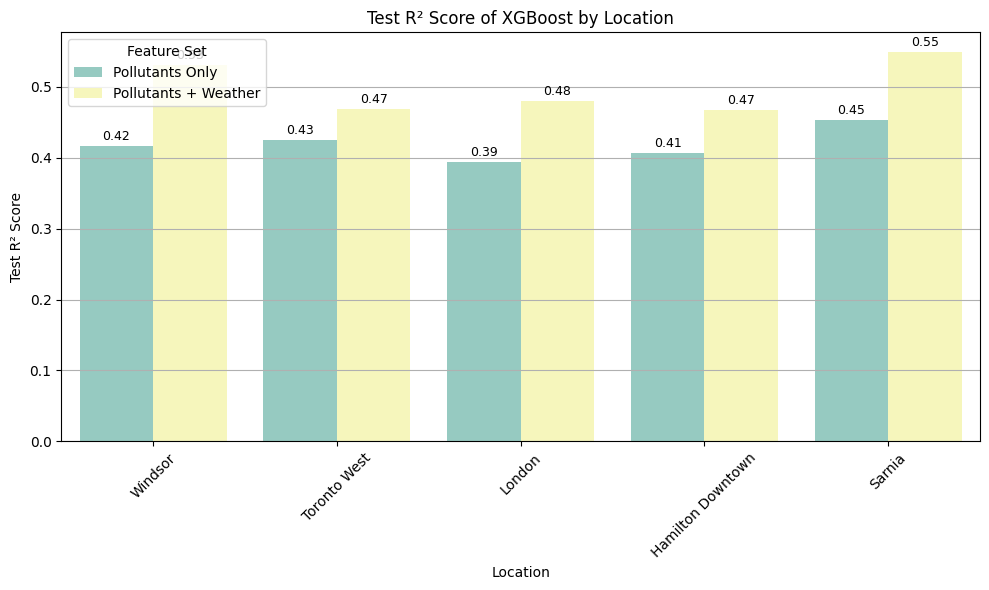

In [10]:
def add_labels(ax):
    """Add value labels on top of each bar"""
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2, fontsize=9)

# Plot 1: Test Accuracy
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(
    data=results_df,
    x='Location',
    y='Test Accuracy',
    hue='Feature Set',
    palette='Set2',
    dodge=True,
    edgecolor='none',
   errorbar=None

)
add_labels(ax1)
plt.title(' Test Accuracy of XGBoost by Location')
plt.xticks(rotation=45)
plt.ylabel('Test Accuracy')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot 2: Test RMSE
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(
    data=results_df,
    x='Location',
    y='Test RMSE',
    hue='Feature Set',
    palette='Set1',
    dodge=True,
    edgecolor='none',
    errorbar=None
)
add_labels(ax2)
plt.title(' Test RMSE of XGBoost by Location')
plt.xticks(rotation=45)
plt.ylabel('Test RMSE')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot 3: Test R²
plt.figure(figsize=(10, 6))
ax3 = sns.barplot(
    data=results_df,
    x='Location',
    y='Test R²',
    hue='Feature Set',
    palette='Set3',
    dodge=True,
    edgecolor='none',
    errorbar=None
)
add_labels(ax3)
plt.title('Test R² Score of XGBoost by Location')
plt.xticks(rotation=45)
plt.ylabel('Test R² Score')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


**Classification**

In [11]:
# Encode target and prepare data
features = selected_features
target = 'AQHI_Category'

df = df.dropna(subset=features + [target])
X = df[features].copy()
X.columns = [col.replace(" ", "_") for col in X.columns]
y = df[target]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Model training and evaluation
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', verbosity=0),
    'LightGBM': LGBMClassifier(verbose=-1),
    'CatBoost': CatBoostClassifier(verbose=0)
}


==== Training on Feature Set: Pollutants Only ====

RandomForest - Accuracy: 0.8718
              precision    recall  f1-score   support

        High       0.54      0.30      0.38        88
         Low       0.91      0.94      0.93     22196
    Moderate       0.60      0.49      0.54      3966

    accuracy                           0.87     26250
   macro avg       0.68      0.58      0.62     26250
weighted avg       0.86      0.87      0.87     26250



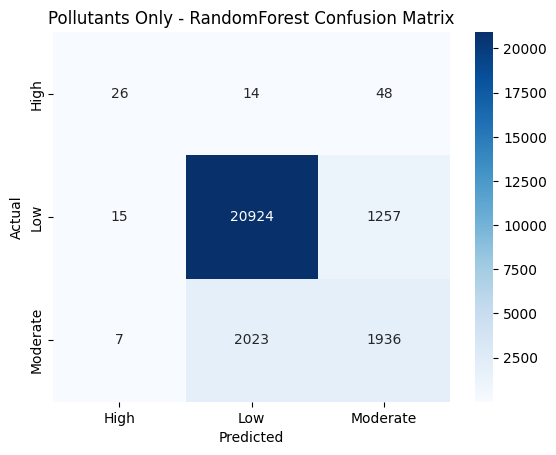


XGBoost - Accuracy: 0.8954
              precision    recall  f1-score   support

        High       0.51      0.22      0.30        88
         Low       0.91      0.97      0.94     22196
    Moderate       0.75      0.47      0.58      3966

    accuracy                           0.90     26250
   macro avg       0.72      0.55      0.61     26250
weighted avg       0.89      0.90      0.88     26250



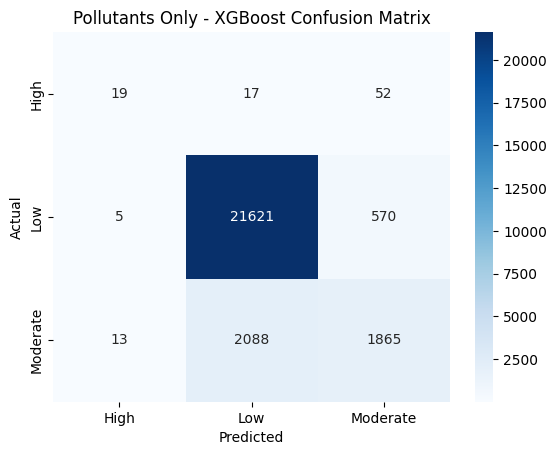


LightGBM - Accuracy: 0.8968
              precision    recall  f1-score   support

        High       0.51      0.32      0.39        88
         Low       0.91      0.97      0.94     22196
    Moderate       0.76      0.48      0.59      3966

    accuracy                           0.90     26250
   macro avg       0.73      0.59      0.64     26250
weighted avg       0.89      0.90      0.89     26250



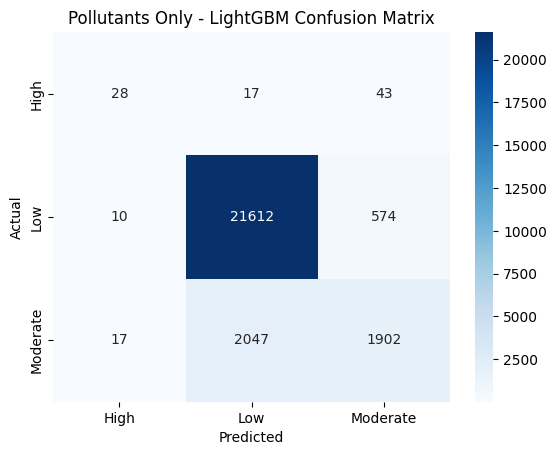


CatBoost - Accuracy: 0.8976
              precision    recall  f1-score   support

        High       0.70      0.32      0.44        88
         Low       0.91      0.97      0.94     22196
    Moderate       0.76      0.48      0.59      3966

    accuracy                           0.90     26250
   macro avg       0.79      0.59      0.66     26250
weighted avg       0.89      0.90      0.89     26250



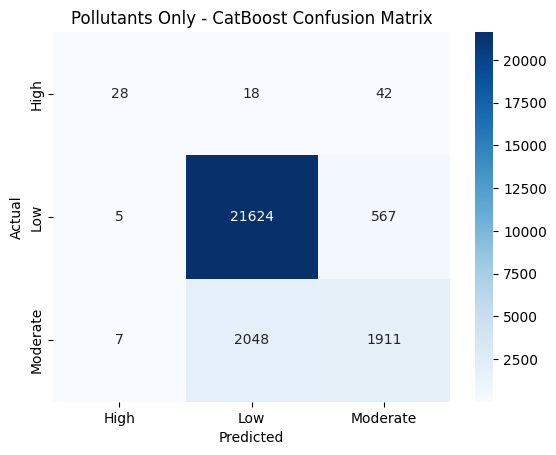


==== Training on Feature Set: Pollutants + Weather ====

RandomForest - Accuracy: 0.8967
              precision    recall  f1-score   support

        High       0.78      0.35      0.48        88
         Low       0.92      0.96      0.94     22196
    Moderate       0.72      0.53      0.61      3966

    accuracy                           0.90     26250
   macro avg       0.80      0.62      0.68     26250
weighted avg       0.89      0.90      0.89     26250



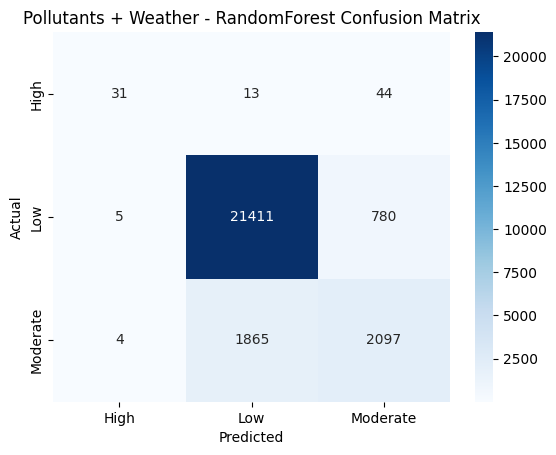


XGBoost - Accuracy: 0.9013
              precision    recall  f1-score   support

        High       0.67      0.33      0.44        88
         Low       0.92      0.97      0.94     22196
    Moderate       0.75      0.52      0.62      3966

    accuracy                           0.90     26250
   macro avg       0.78      0.61      0.67     26250
weighted avg       0.89      0.90      0.89     26250



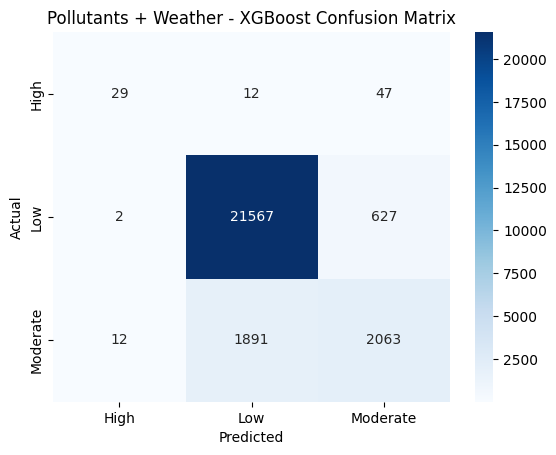


LightGBM - Accuracy: 0.9002
              precision    recall  f1-score   support

        High       0.50      0.33      0.40        88
         Low       0.92      0.97      0.94     22196
    Moderate       0.75      0.52      0.61      3966

    accuracy                           0.90     26250
   macro avg       0.72      0.61      0.65     26250
weighted avg       0.89      0.90      0.89     26250



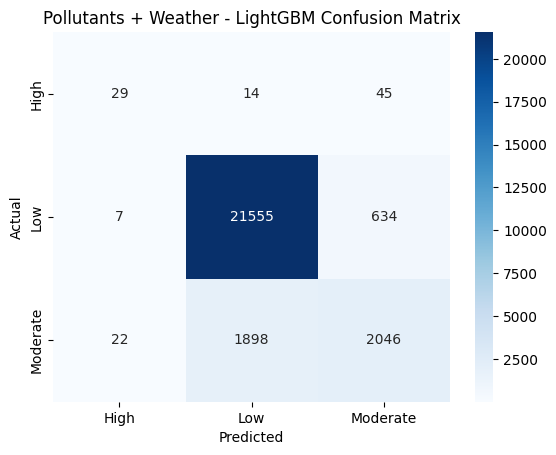


CatBoost - Accuracy: 0.9027
              precision    recall  f1-score   support

        High       0.81      0.34      0.48        88
         Low       0.92      0.97      0.95     22196
    Moderate       0.76      0.52      0.62      3966

    accuracy                           0.90     26250
   macro avg       0.83      0.61      0.68     26250
weighted avg       0.90      0.90      0.89     26250



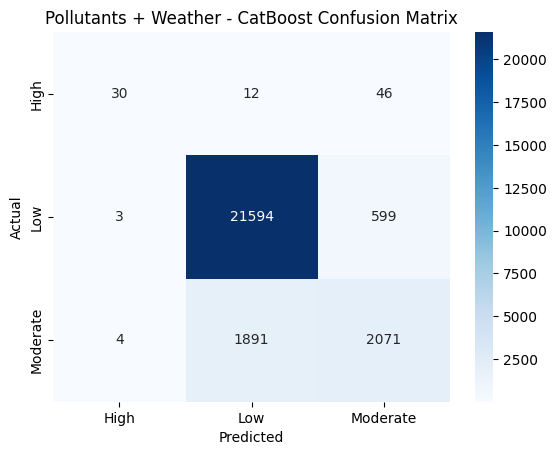

In [12]:
# Define feature subsets
feature_sets = {
    "Pollutants Only": ['PM2.5', 'O3', 'NO2'],
    "Pollutants + Weather": ['PM2.5', 'O3', 'NO2', 'Temp (°C)']
}

# Dictionary to store results
comparison_results = {}

# Loop over feature sets
for set_name, features in feature_sets.items():
    print(f"\n==== Training on Feature Set: {set_name} ====")

    # Subset data
    X = df[features]
    y = df['AQHI_Category']

    # Encode target labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    # Define models
    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='mlogloss', verbosity=0),
        'LightGBM': LGBMClassifier(verbose=-1),
        'CatBoost': CatBoostClassifier(verbose=0)
    }

    # Store results for this set
    comparison_results[set_name] = {}

    # Train and evaluate
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f"\n{name} - Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
        plt.title(f'{set_name} - {name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Save accuracy for comparison
        comparison_results[set_name][name] = acc

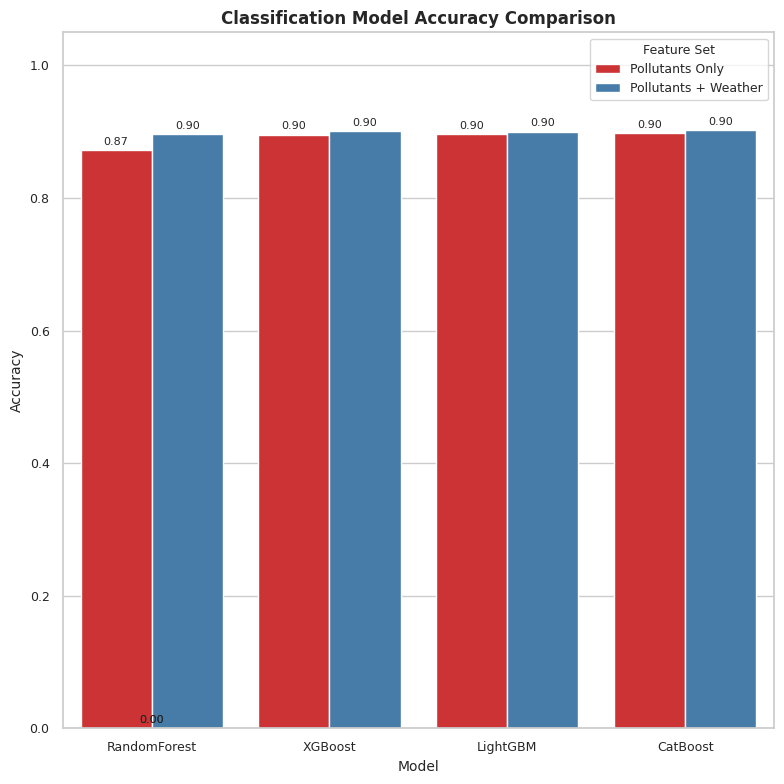

In [24]:
comparison_df = pd.DataFrame(comparison_results)

comparison_long = comparison_df.reset_index().melt(
    id_vars='index',
    var_name='Feature Set',
    value_name='Accuracy'
)
comparison_long.rename(columns={'index': 'Model'}, inplace=True)

# Plot: compact style with accurate labels
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
ax = sns.barplot(data=comparison_long, x='Model', y='Accuracy', hue='Feature Set', palette='Set1')

# Add accuracy labels above each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height + 0.005),
                ha='center', va='bottom', fontsize=8)

# Style and layout
plt.title("Classification Model Accuracy Comparison", fontsize=12, weight='bold')
plt.xlabel("Model", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.ylim(0, 1.05)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title="Feature Set", fontsize=9, title_fontsize=9, loc='upper right')
plt.tight_layout()
plt.show()


/tmp/ipython-input-14-3719063067.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_mean = df_loc[pollutants].resample('M').mean().interpolate()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


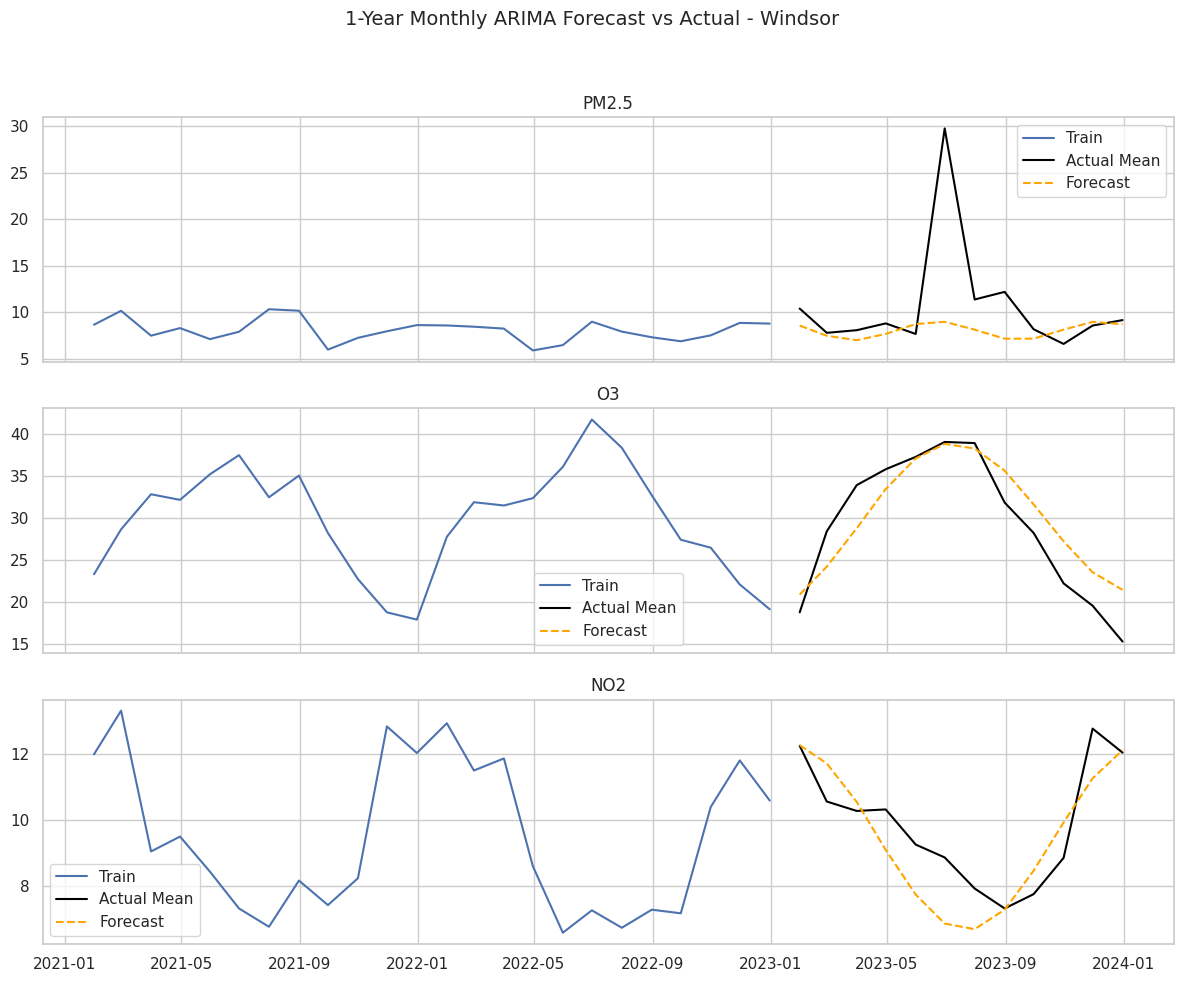

/tmp/ipython-input-14-3719063067.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_mean = df_loc[pollutants].resample('M').mean().interpolate()


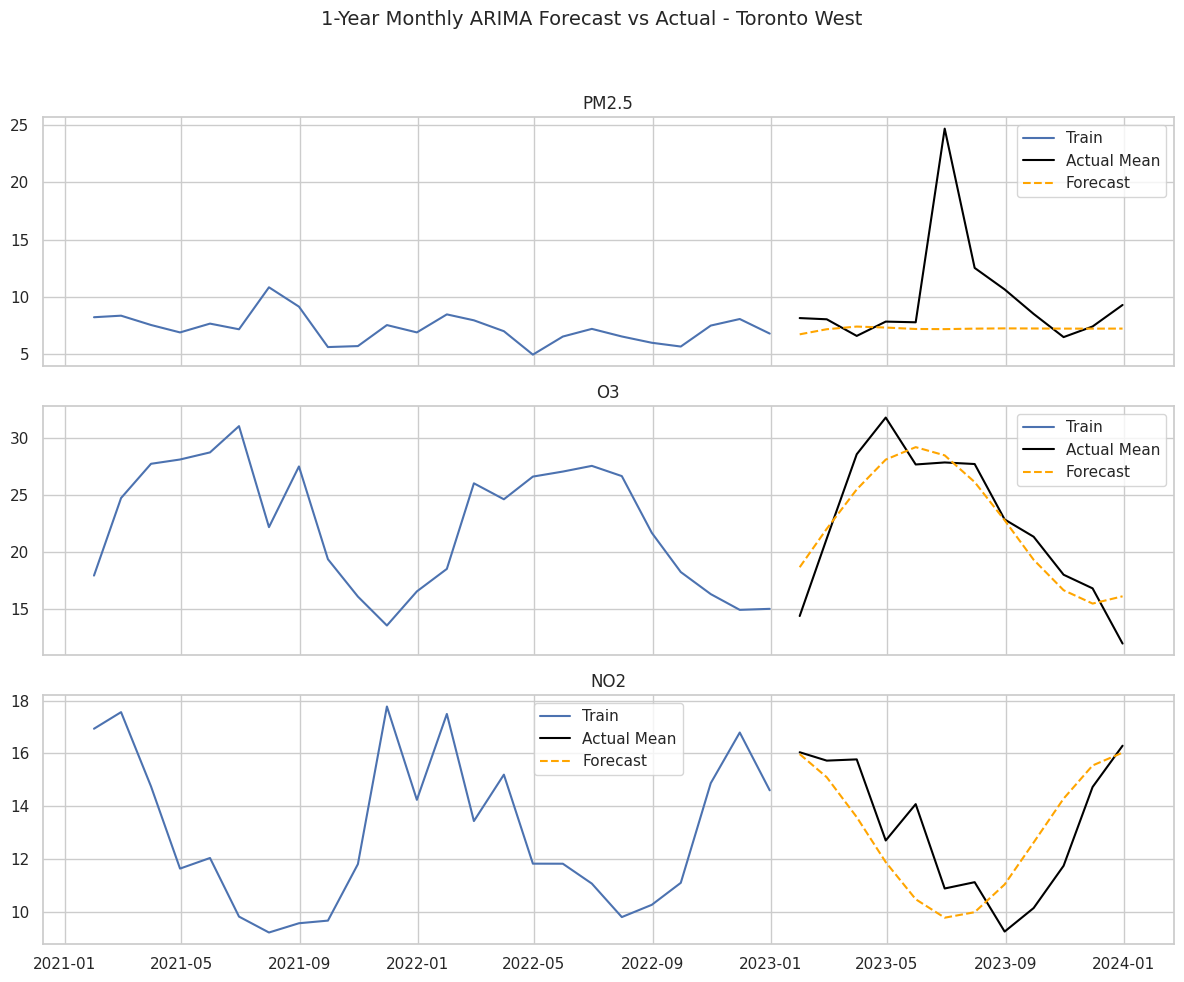

/tmp/ipython-input-14-3719063067.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_mean = df_loc[pollutants].resample('M').mean().interpolate()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


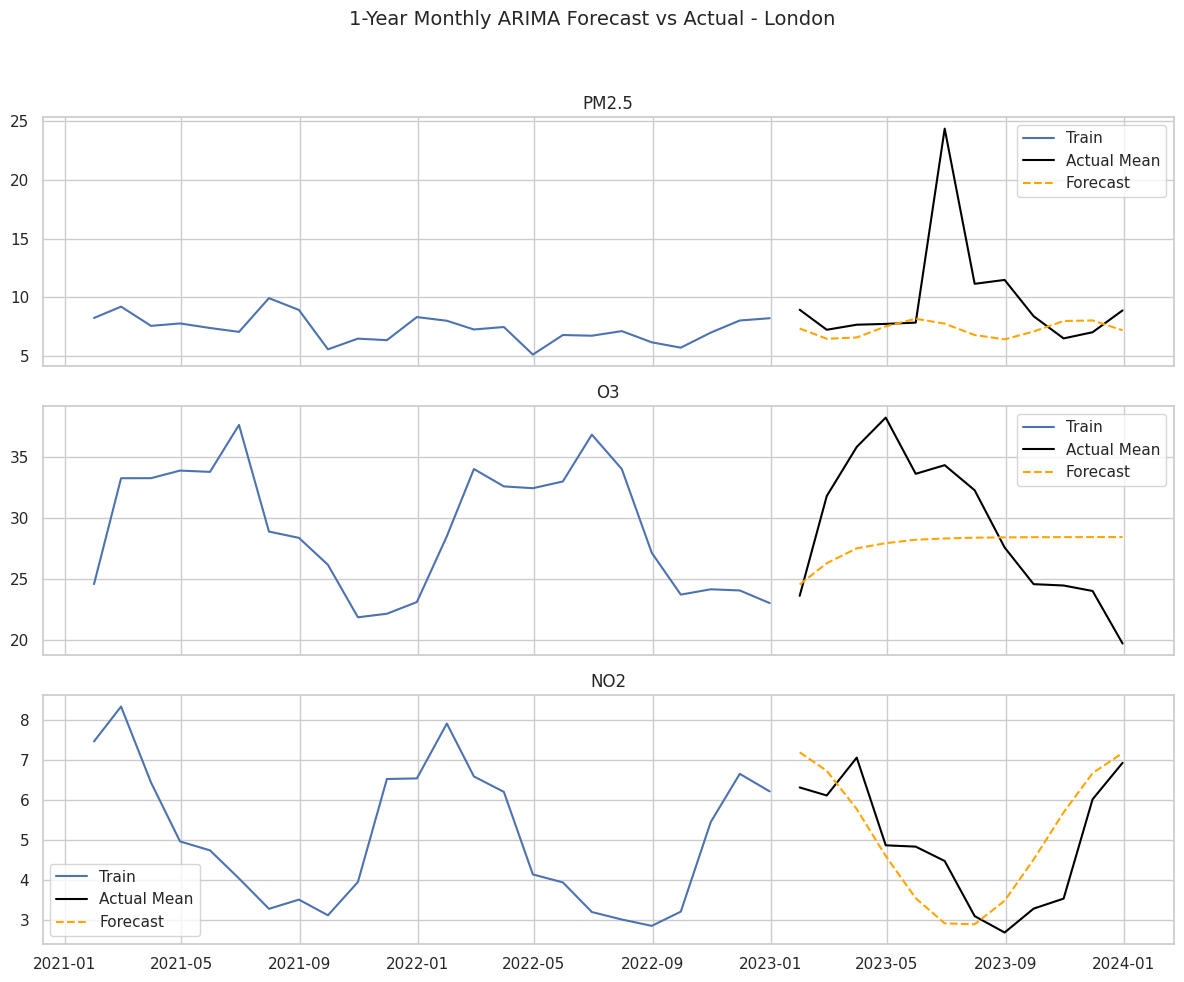

/tmp/ipython-input-14-3719063067.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_mean = df_loc[pollutants].resample('M').mean().interpolate()


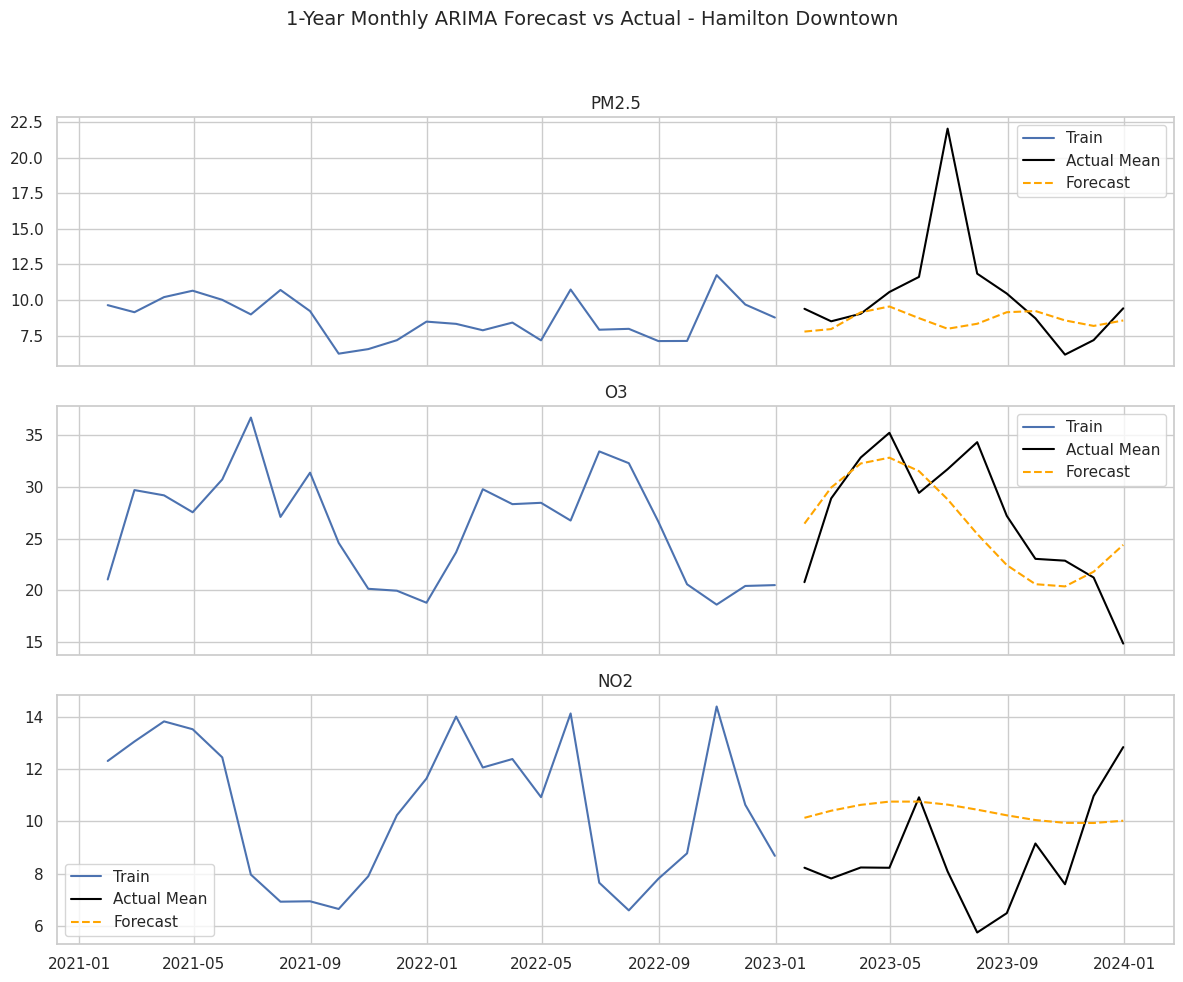

/tmp/ipython-input-14-3719063067.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_mean = df_loc[pollutants].resample('M').mean().interpolate()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


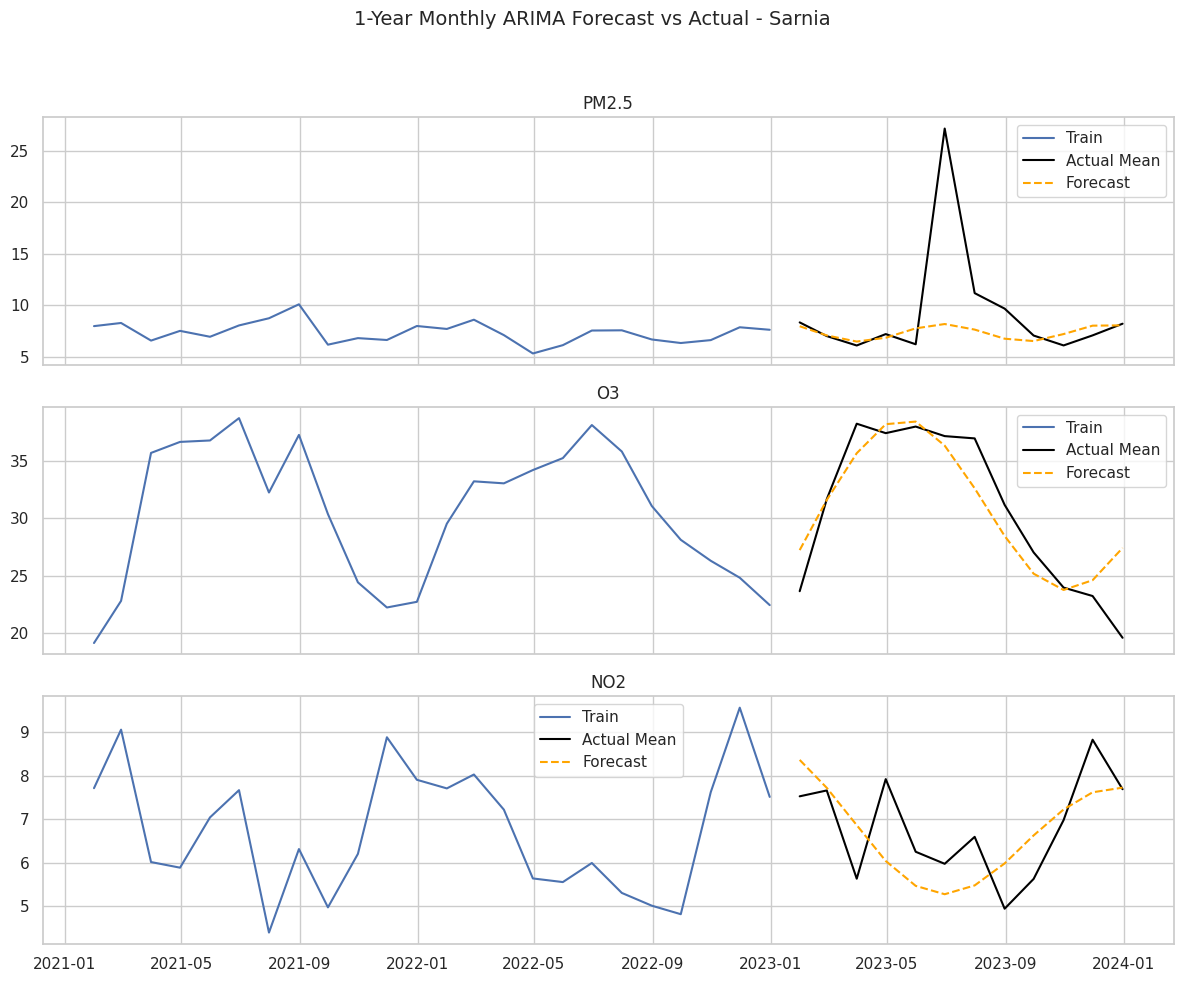

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")


# Ensure datetime format
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

# List of pollutants to forecast
pollutants = ['PM2.5', 'O3', 'NO2']

# Loop through each location
locations = df['Location'].unique()

for loc in locations:
    df_loc = df[df['Location'] == loc].copy()
    df_loc.set_index('TimeStamp', inplace=True)

    # Resample to monthly mean
    df_monthly_mean = df_loc[pollutants].resample('M').mean().interpolate()

    # Use last 36 months: 24 for training, 12 for forecasting
    if len(df_monthly_mean) < 36:
        continue  # skip if not enough data

    df_monthly_mean = df_monthly_mean[-36:]
    df_train = df_monthly_mean[:-12]
    df_actual_mean = df_monthly_mean[-12:]

    # Subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"1-Year Monthly ARIMA Forecast vs Actual - {loc}", fontsize=14)

    for i, pol in enumerate(pollutants):
        ts_train = df_train[pol]
        ts_mean_actual = df_actual_mean[pol]

        # ADF Test
        adf_stat, adf_pval, _, _, _, _ = adfuller(ts_train)
        #print(f"{loc} - {pol} ADF p-value: {adf_pval:.4f}")

        # Fit ARIMA model
        model = ARIMA(ts_train, order=(2, 0, 2))
        fit = model.fit()
        forecast = fit.forecast(steps=12)

        # Plotting
        axs[i].plot(ts_train[-24:], label='Train')
        axs[i].plot(ts_mean_actual.index, ts_mean_actual.values, label='Actual Mean', color='black')
        axs[i].plot(ts_mean_actual.index, forecast, label='Forecast', linestyle='--', color='orange')
        axs[i].set_title(f"{pol}")
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


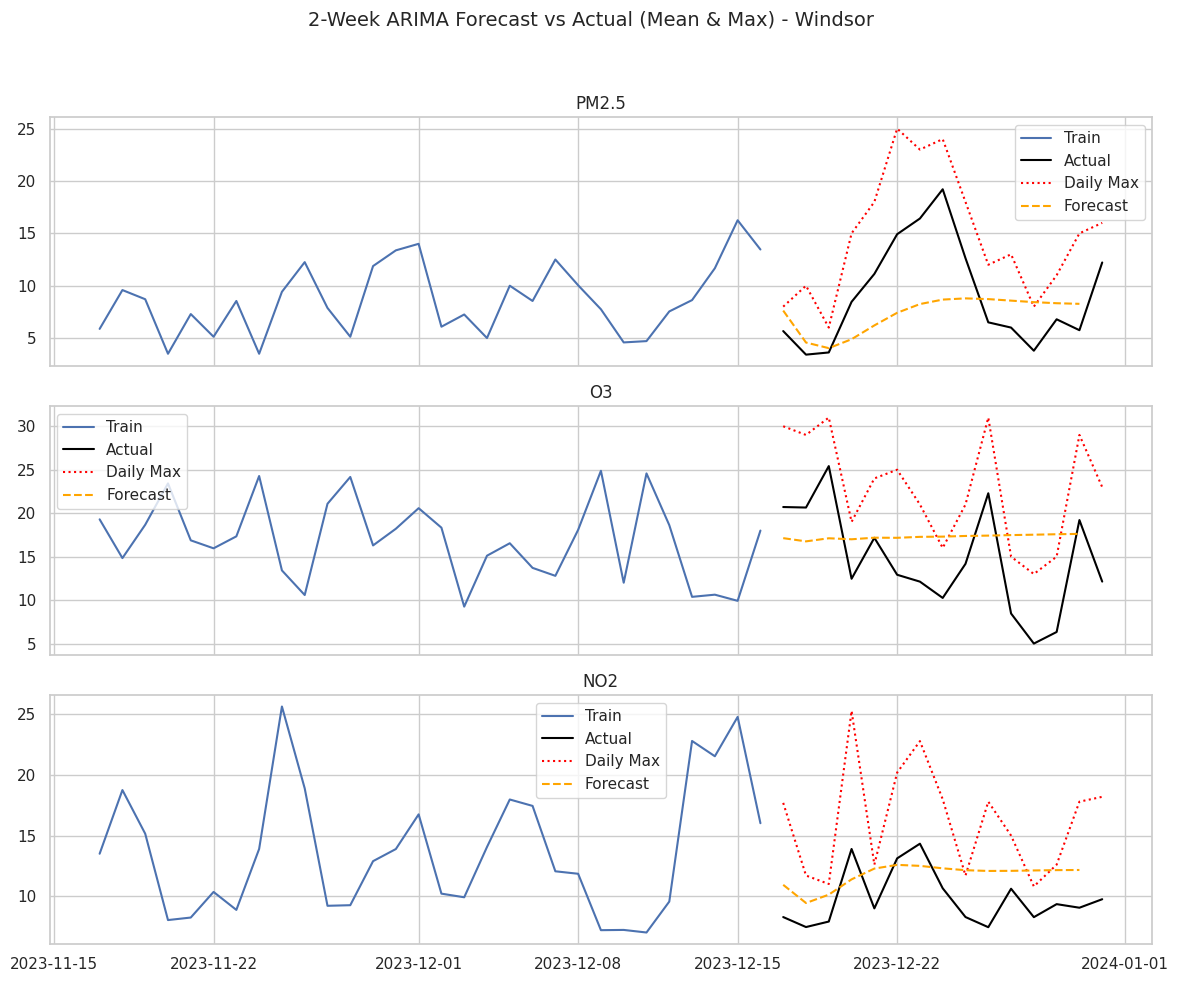

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


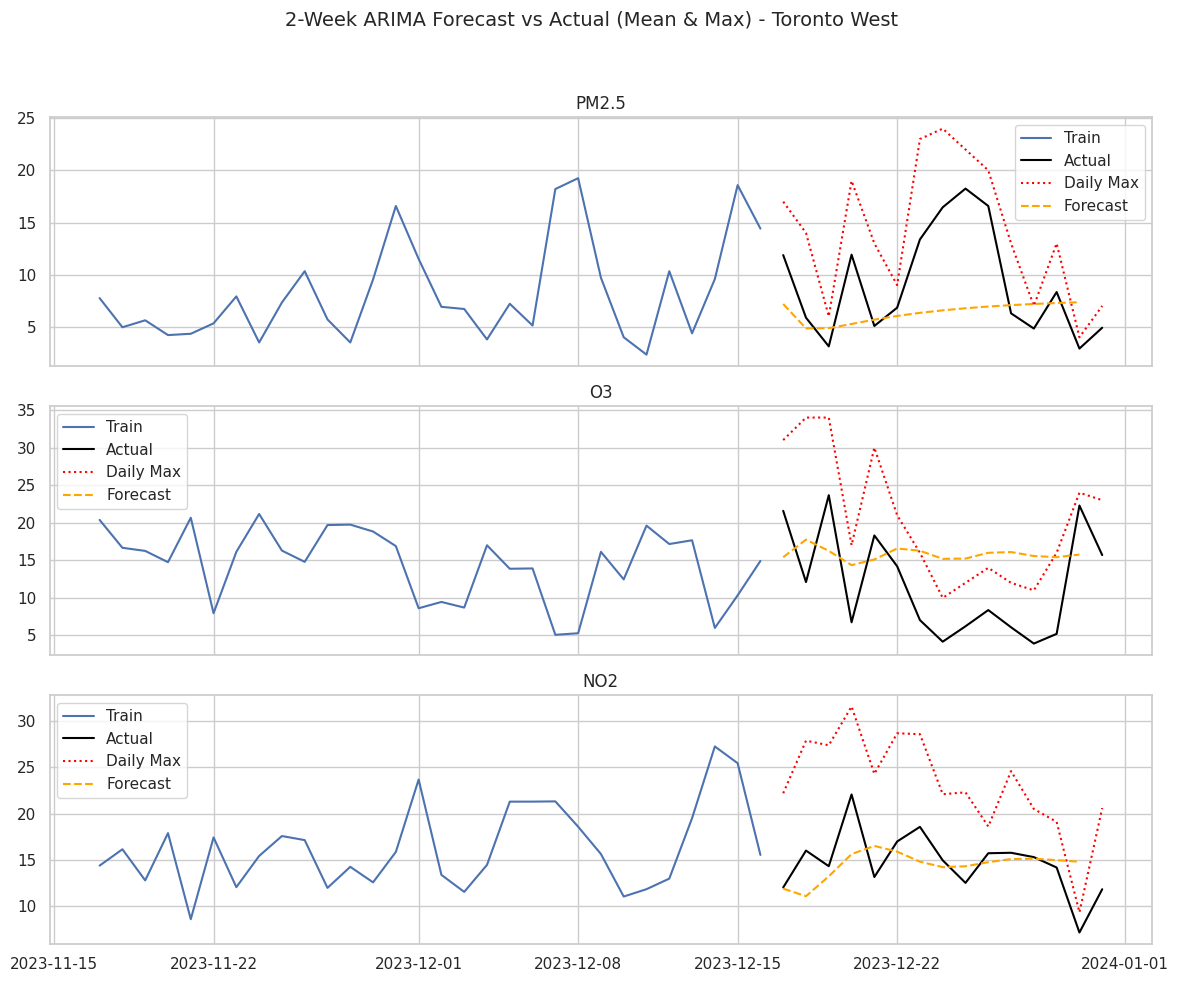

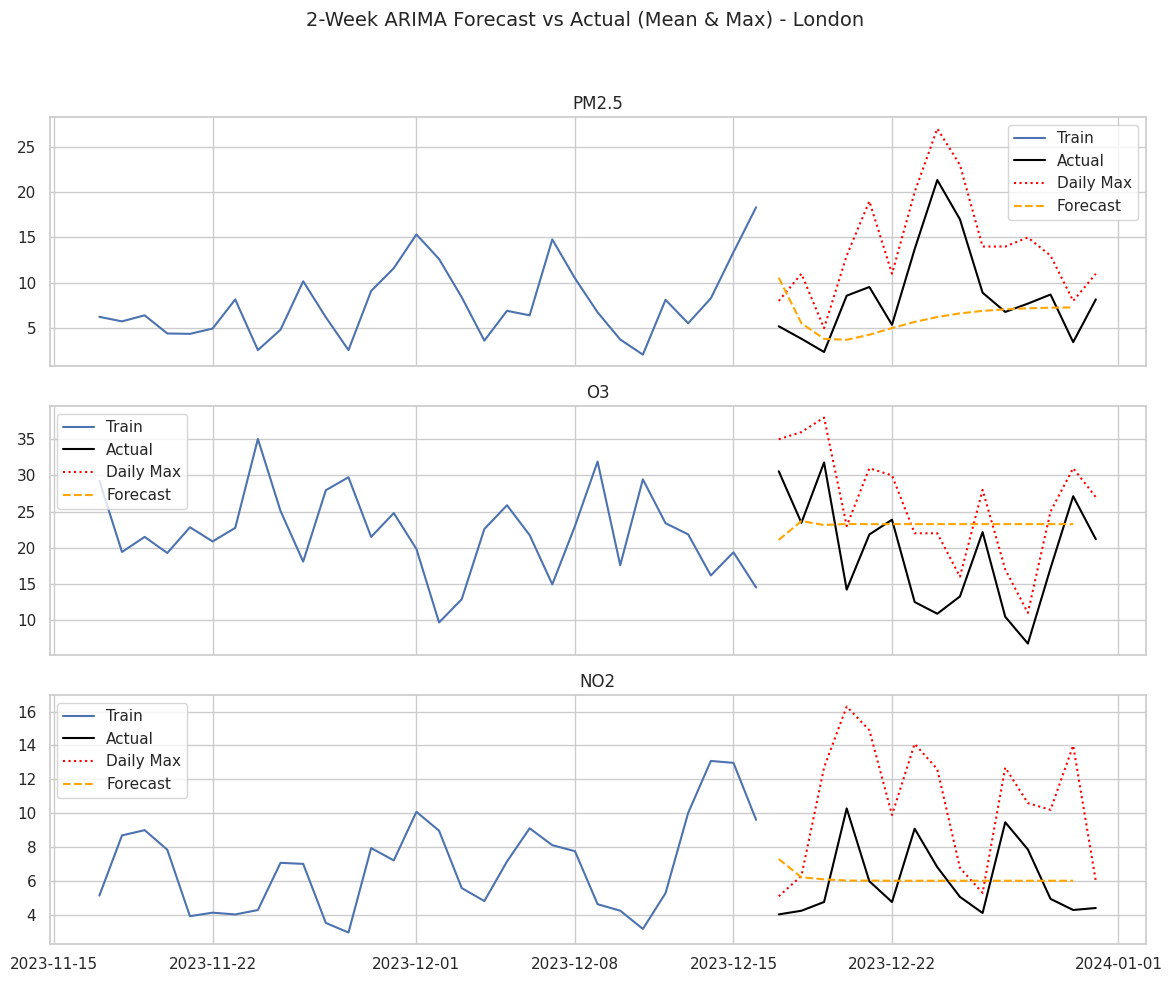

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


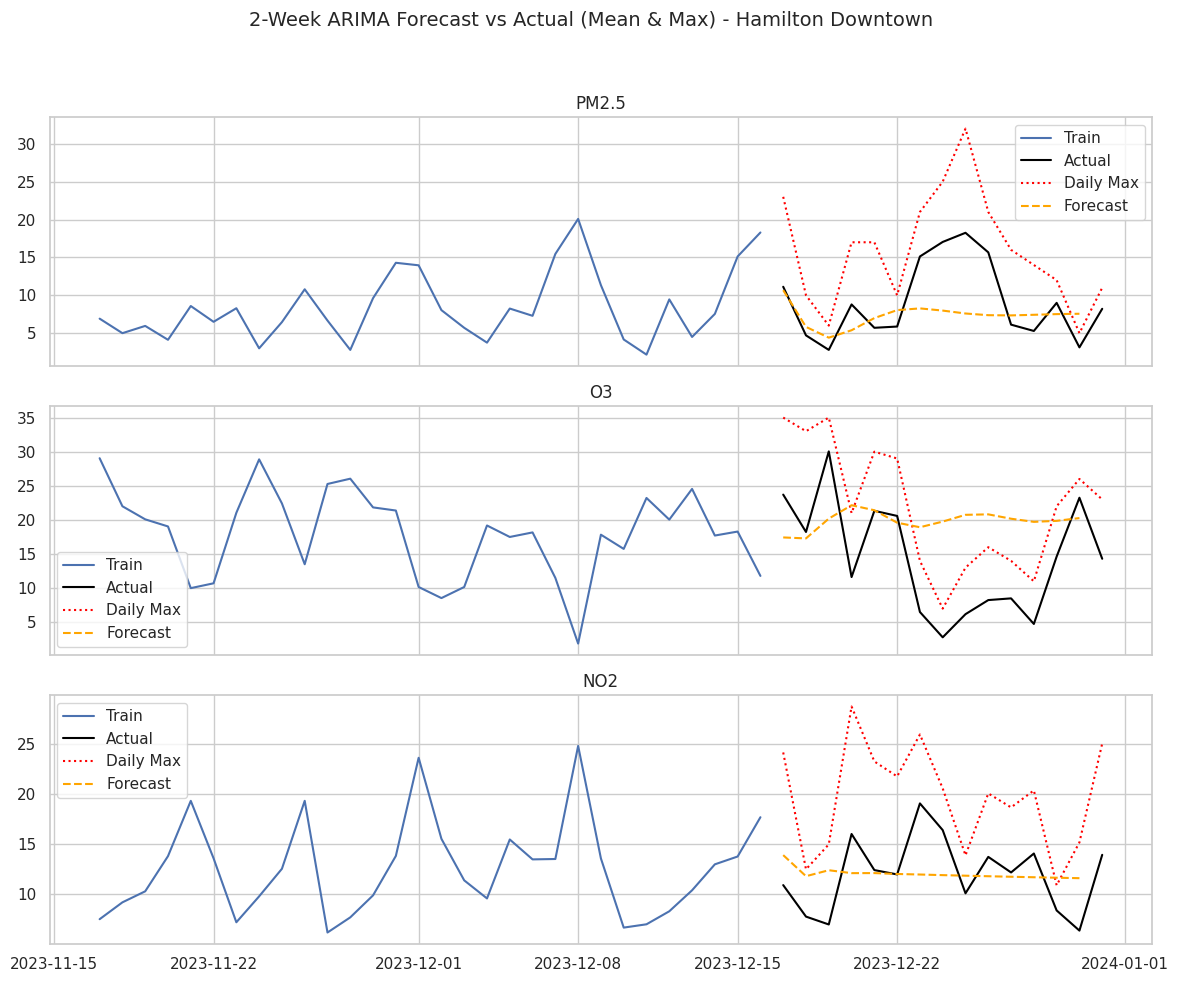

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


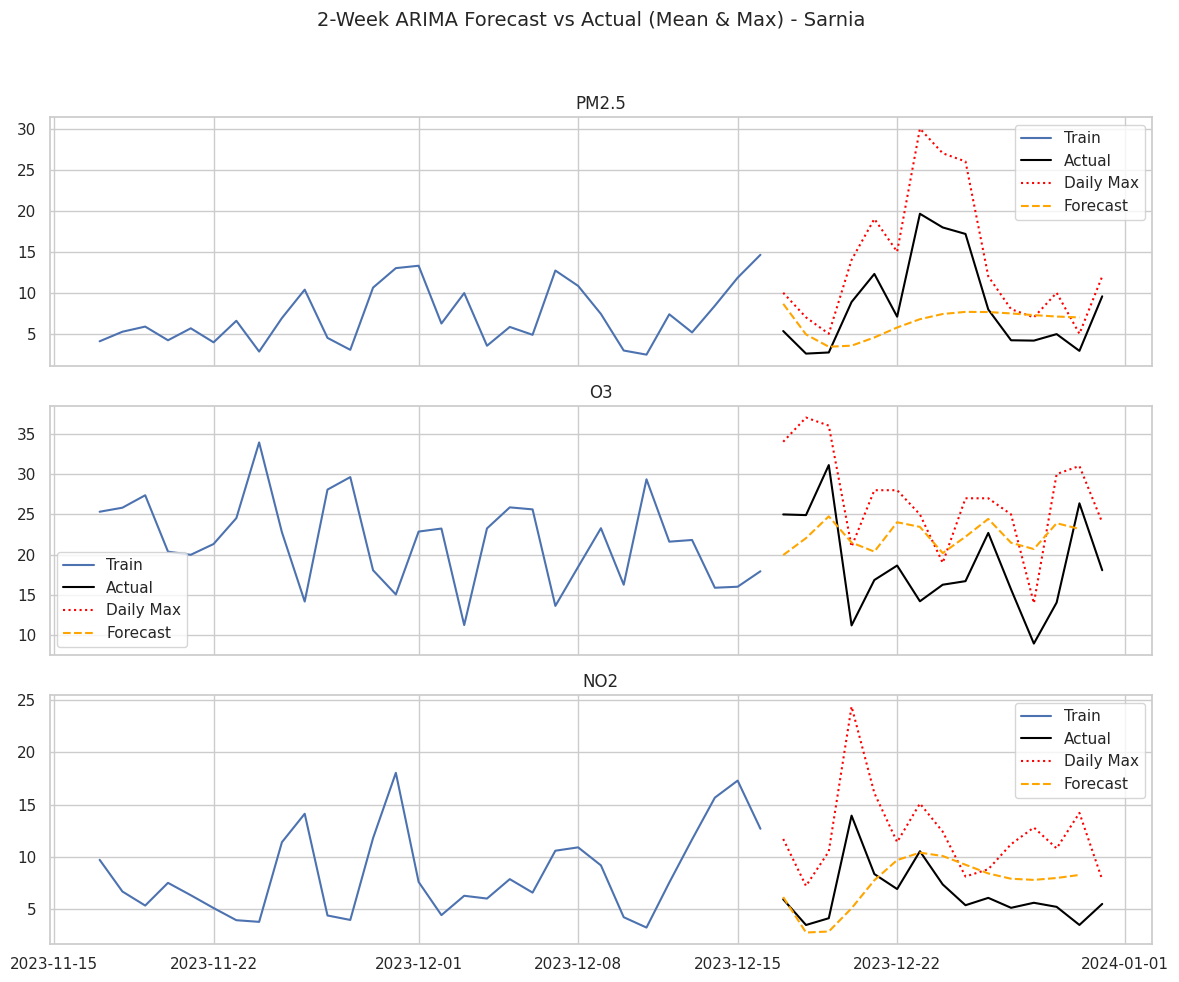

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")

# Ensure datetime format
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

# List of pollutants to forecast
pollutants = ['PM2.5', 'O3', 'NO2']

# Loop through each location
locations = df['Location'].unique()

for loc in locations:
    df_loc = df[df['Location'] == loc].copy()
    df_loc.set_index('TimeStamp', inplace=True)

    # Resample to daily mean and max
    df_daily_mean = df_loc[pollutants].resample('D').mean().interpolate()
    df_daily_max = df_loc[pollutants].resample('D').max().interpolate()

    # Define time windows
    forecast_days = 14
    max_date = df_daily_mean.index.max()
    cutoff_date = max_date - pd.Timedelta(days=forecast_days)
    train_end = cutoff_date - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=59)

    df_train = df_daily_mean.loc[train_start:train_end]
    df_actual_mean = df_daily_mean.loc[cutoff_date:max_date]
    df_actual_max = df_daily_max.loc[cutoff_date:max_date]

    # Subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"2-Week ARIMA Forecast vs Actual (Mean & Max) - {loc}", fontsize=14)

    for i, pol in enumerate(pollutants):
        ts_train = df_train[pol]
        ts_mean_actual = df_actual_mean[pol]
        ts_max_actual = df_actual_max[pol]

        model = ARIMA(ts_train, order=(2, 0, 2))
        fit = model.fit()
        forecast = fit.forecast(steps=forecast_days)

        # Plotting
        axs[i].plot(ts_train[-30:], label='Train')
        axs[i].plot(ts_mean_actual.index, ts_mean_actual.values, label='Actual', color='black')
        axs[i].plot(ts_max_actual.index, ts_max_actual.values, label='Daily Max', color='red', linestyle=':')
        axs[i].plot(forecast.index, forecast, label='Forecast', linestyle='--', color='orange')
        axs[i].set_title(pol)
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
